<div style="background-color:royalblue">
<img src="https://d3njjcbhbojbot.cloudfront.net/web/bundles/userModal/images/coursera-logo.svg">
</div>    

# <b style="color:#3b5998">www-coursera-downloader-multi-course</b>

- this notebook release: 201600709
- notebook features: 
  - fixed bug in quiz downloader
  - html reading downloader
  - video downloader
  - creation of m3u playlist
  - added  <b style="color:#3b5998">colorful</b> heading and images
  - added section `download another course?`
  - handle courses with only `Preview Week 1`
  - added TOC
  - handle subtitle not available
  - separation of quiz downloader

(c) Jansen Simanullang, 2016-2018.

## <div align='center'><a href='#toc'><b style='color:#3b5998'>TABLE OF CONTENTS</b></a></div>
### <a href='#all'><b style="color:#3b5998">A. All Required Software</b></a>
### <a href='#before'><b style="color:#3b5998">B. Before Login</b></a>
### <a href='#coursera'><b style="color:#3b5998">C. Coursera</b></a>
### <a href='#download'><b style="color:#3b5998">D. Download Another Course?</b></a>
### <a href='#error'><b style="color:#3b5998">E. Error Checking</b></a>
### <a href='#finally'><b style="color:#3b5998">F. Finally Close the Browser</b></a>
### <a href='#goodbye'><b style="color:#3b5998">G. Go Back to Login</a></b>

## <a name = 'all'><b style='color:#3b5998'>A. All Required Softwares</b></a>

Run once to install all required software.

### <b style='color:#3b5998'>(1) Install Mozilla Geckodriver</b>
<img src="https://avatars2.githubusercontent.com/u/131524?s=200&v=4" width="75" height="75" alt="@mozilla" align="center"><br>
<li>Install [Mozilla Geckodriver](https://github.com/mozilla/geckodriver/releases/)
</li>

#### <b style="color:royalblue">Check Geckodriver version</b>

In [1]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### <b style="color:#3b5998">(2) Install Some Python Packages</b>
<img src="https://pypi.org/static/images/logo-small.6eef541e.svg">

In [ ]:
!pip install -q jupyter_contrib_nbextensions jupyter_nbextensions_configurator
!pip install -q bs4 mutagen pillow requests splinter
!jupyter contrib nbextension install --user
!jupyter nbextensions_configurator enable --user
!jupyter nbextension enable python-markdown/main

## <a name='before'><b style="color:#3b5998">B. Before Login</b></a>

### <b style="color:#3b5998">B. 1 Python Package Imports</b>

In [1]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup
from mutagen.mp4 import MP4

### <b style="color:royalblue">B. 2 Some Constants</b>

In [2]:
# LOADING TIME
# WARNING: this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5

# HOMEPAGE
homepage='https://www.coursera.org'

# VIDEO RESOLUTION
# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
resolution = {'low':'360','med':'540','hi':'720'}
chosen_res = 'hi'

# INITIAL DIRECTORY
initial_dirname = os.getcwd()

###  <b style="color:royalblue">B.3 Helper Functions</b>

<img src="https://www.3di.co.uk/wp-content/uploads/2016/06/Define.png" height="150" width="250">

In [3]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

# SCREENSHOT
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

# button click
def button_click(text_):
    try:
        buttons = browser.find_by_css('button')
        for button in buttons:
            if button.text == text_:
                print(text_)
                button.click()
                break
    except:
        pass

# cjson helper functions

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

# vtt file conversion

def read_text_file(file_name):
    f = open(file_name, "r")
    print("\nvtt file being converted to srt: " + file_name)  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name)
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)
    
# 
    
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [4]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        try:
            vtt = get_vtt_url(lesson_url)
            r = requests.get(vtt)
            f = open(file_name, 'w')
            f.write(r.text)
            f.close()
            vtt_to_srt(file_name)
        except:
            print('subtitle not yet available')
            pass
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.0f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [5]:
def reformat_html(html, page_title):
    
    # reading
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>',
                        '')
    
    return html    
    
def reformat_html_quiz(html, page_title):    
    # quiz
    html = html.replace('<div class="header-back-arrow"><button class="back nostyle" role="button" tabindex="0"><i class="cif-back headline-2-text"></i><span class="screenreader-only">Back</span></button></div>',
                        '')
    html = html.replace('<div data-rc="ItemFeedback" class="c-quiz-item-feedback"><div data-reactroot="" class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div>',
                        '')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def write_html_quiz(base_filename, html):
    
    html = reformat_html_quiz(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
    
    
def quiz_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    button_click('Continue')
    button_click('Start')
    button_click('Resume')
    button_click('Start Quiz')
    
    try:
        time.sleep(loading_time)
        html = browser.find_by_css('div.rc-FullscreenLayoutHandler').html
        print('got quiz item')
        base_filename = lesson_id +'-'+ safe_text(lesson_title)
        write_html_quiz(base_filename, html)
    except:
        print('something wrong...')
        html ='no quiz content scraped.'
        pass
    

    
def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    try:
        write_html(base_filename, html)
    except:
        # file name too long
        write_html(base_filename[:55], html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)
        

def check_mp4(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('mp4 already downloaded.')
    else:
        mp4_downloader(lesson_id, lesson_title, lesson_url)
        
        
def check_vtt(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.vtt'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('vtt already downloaded.')
    else:
        vtt_downloader(lesson_id, lesson_title, lesson_url)
        

def check_quiz(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('quiz already downloaded.')
    else:
        quiz_downloader(lesson_id, lesson_title, lesson_url)
        
### CREATE m3u PLAYLIST FILE
def create_m3u_playlist(course_title):
    
    seq = 0
    m3u_text = '#EXTM3U'+'\n'
    for root, dirs, files in os.walk(os.getcwd(), topdown=False):
        for name in sorted(files):
            if 'mp4' in name:
                seq += 1
                #mp4 = os.path.join(root, name)
                mp4 = (name)
                m3u_text += ('#EXTINF:'+str(int((MP4(mp4).info.length)))+','+ name) + '\n'
                m3u_text += (mp4) + '\n'
    playlist_base_name = safe_text(course_title).replace(' ','-')
    playlist_name = '000-'+playlist_base_name + '.m3u'
    f = open(playlist_name, 'w')
    f.write(m3u_text)
    f.close()
    print('playlist file created: '+playlist_name)

In [ ]:
def enumerate_weeks(lecture_homepage):
    
    browser.visit(lecture_homepage)
    time.sleep(loading_time)
    weeks = []
    
    if browser.find_by_text('Preview Week 1'):
        
        week = lecture_homepage.replace('welcome','week/')
        week = week[week.index('/learn'):]
        sys.stdout.write('week preview\n')
        for i in range(4):
            weeks.append(week + str(i+1))
    
    else:
    
        week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
        anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
        sys.stdout.write('\rweeks list\n')
        for a in anchors:
            weeks.append(a['href']) 
            
    sys.stdout.flush()

    return weeks

In [49]:
def enumerate_lessons(lecture_homepage):
    
    weeks = enumerate_weeks(lecture_homepage)
    w_digit = len(str(len(weeks)))

    lessons_i = []
    lessons_t = []
    lessons_u = []
    
    for w in range(len(weeks)):
    
        sys.stdout.write('\r'+'{:290.40}'.format('Collecting lessons title and urls...'))   
        browser.visit(homepage + weeks[w])
        time.sleep(loading_time)
        w = w+1
    
        sys.stdout.write('\r'+'{:290.40}'.format('Collecting titles and urls from week: ' + str(w)))
        time.sleep(loading_time)
        module_lessons = browser.find_by_css('div.rc-ModuleLessons')
        sys.stdout.flush()
        sys.stdout.write('\rWeek '+str(w)+' titles:')
        seq = 0
        for i, module_lesson in enumerate(module_lessons):

            lessons_title = module_lesson.find_by_tag('h5')

            for j, l in enumerate(lessons_title):
                seq  += 1
                lesson_id = str(w*100+seq).zfill(w_digit+2)
                title = l.text.replace('\n',' ')
                sys.stdout.write('\r'+lesson_id+', '+title)
                title = safe_text(title)
                lessons_t.append(title)
                lessons_i.append(lesson_id)
    
        sys.stdout.flush()
        sys.stdout.write('\rWeek '+str(w)+' links:')    
        seq = 0

        for i, module_lesson in enumerate(module_lessons):

            lessons_url = module_lesson.find_by_tag('ul')
    
            for j, e in enumerate(lessons_url):
                anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
                for k, a in enumerate(anchors):
                    seq += 1
                    lesson_id = str(w*100+seq).zfill(w_digit+2)
                    lesson_url = a['href']
                    sys.stdout.write('\r'+lesson_id+', '+ lesson_url)
                    lessons_u.append(lesson_url)
           
        sys.stdout.flush()
        sys.stdout.write('\rThere are '+str(len(lessons_u)) + ' lesson titles available to check.\n')
    sys.stdout.flush()     
    
    return lessons_i, lessons_t, lessons_u

In [45]:
def download_videos(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
    
        if 'Lecture' in first_word:
            check_mp4(a,b,c)
            vtt_downloader(a,b,c)
            print()
            
        else:
            sys.stdout.write('\rno video resource to download.\n')
        
        sys.stdout.flush()
    sys.stdout.write('\rVideos downloaded to:'+os.getcwd() + '\n')
    os.chdir(initial_dirname)
    
def download_html(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
           
        if 'Reading' in first_word:
            check_html_reading(a, b, c)
            print()
    
        else:
            sys.stdout.write('\rno html resource to download.\n')
        
        print()
    sys.stdout.write('\rHTML Resources downloaded to: '+os.getcwd() + '\n')
    os.chdir(initial_dirname)
    
def download_quiz(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
    
        if ('Quiz' in first_word) or ('Practice Quiz' in b):
            check_quiz(a, b, c)
            sys.stdout.flush()
    
        else:
            sys.stdout.write('\rno quiz to download.\n')
        
        sys.stdout.flush()
    sys.stdout.write('\rQuizzes downloaded to: '+os.getcwd()+'\n')
    os.chdir(initial_dirname)
    
def download_all(lessons):
    for a,b,c in lessons:
        sys.stdout.write(a+','+b)
        first_word = b.split(' ')[0]
    
        if 'Lecture' in first_word:
            check_mp4(a,b,c)
            vtt_downloader(a,b,c)
            print()
        
        elif 'Reading' in first_word:
            check_html_reading(a, b, c)
            print()
        
        elif ('Quiz' in first_word) or ('Practice Quiz' in b):
            check_quiz(a, b, c)
            print()
    
        else:
            sys.stdout.write('\rno resource to download.\n')

##  <a name='coursera'><b style="color:#3b5998">C. Coursera</b></a>

###  <a name='login'><b style="color:royalblue">(1) Login Page</b></a>


In [9]:
browser = Browser('firefox', headless = True)

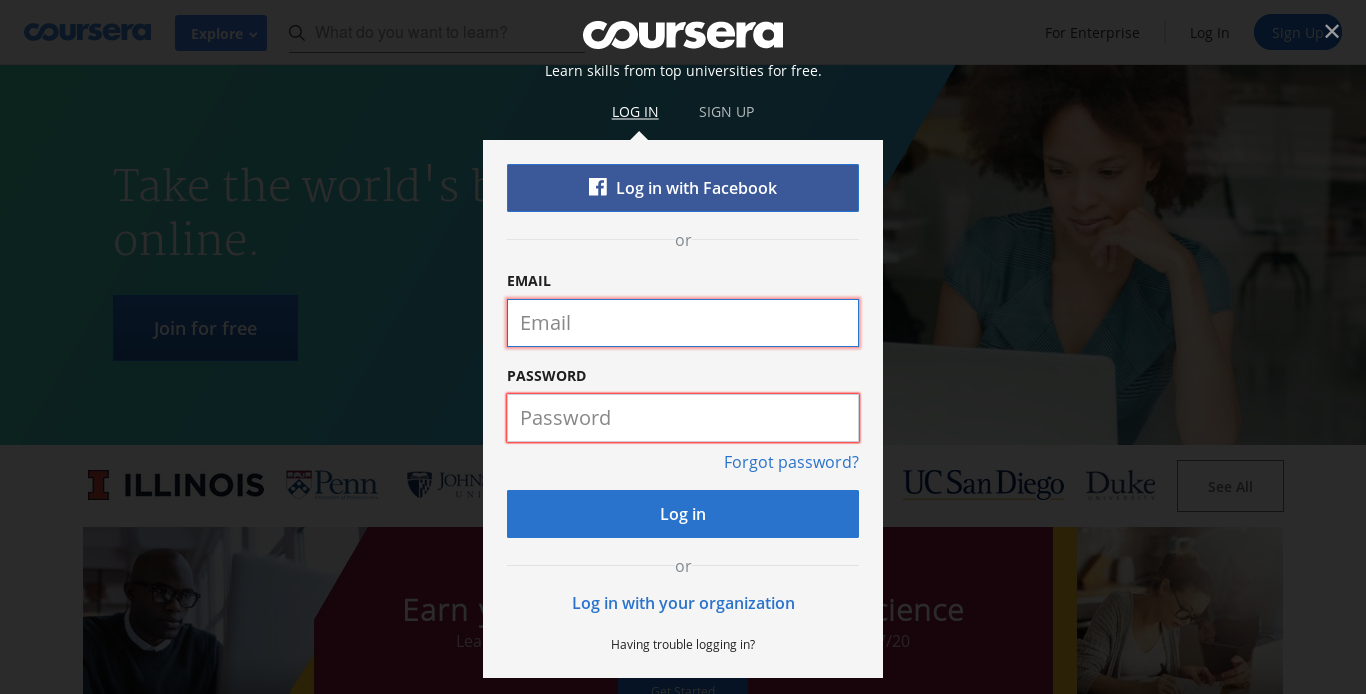

In [10]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

###  <b style="color:royalblue">Insert Login Credential</b>

In [11]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [12]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [13]:
browser.fill('email', username)
browser.fill('password', password)

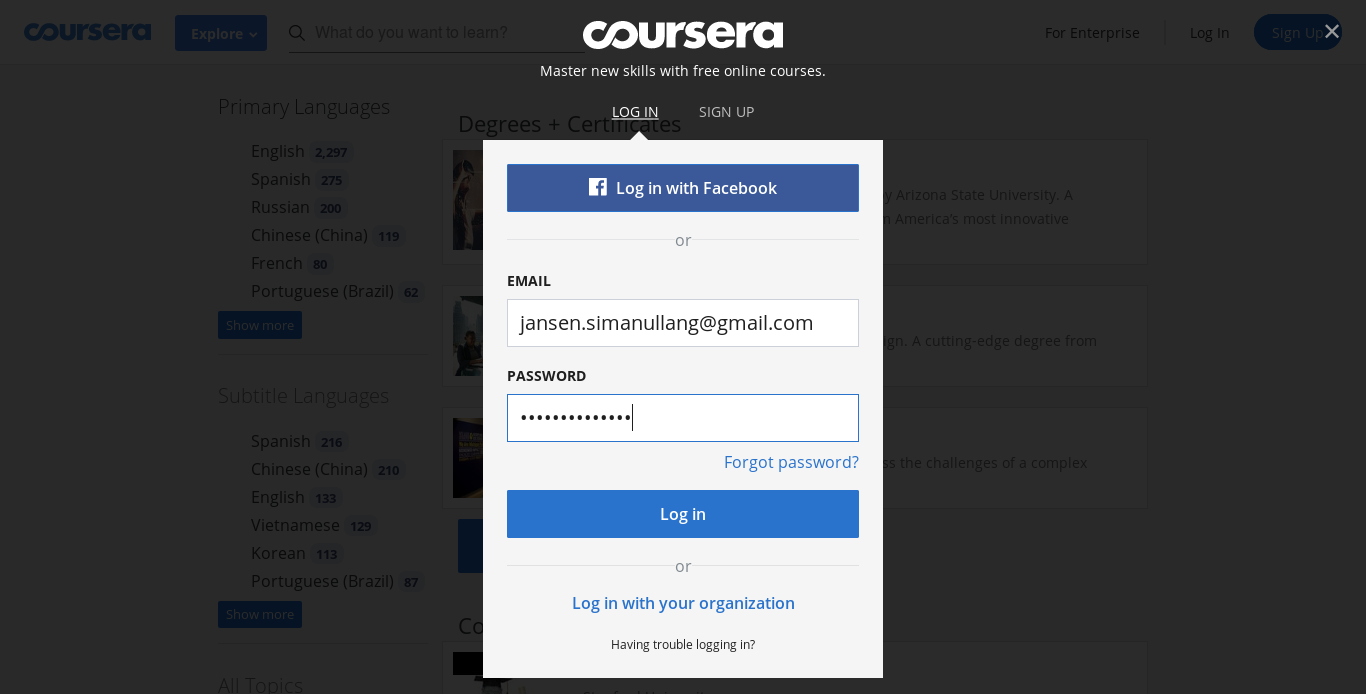

In [14]:
screenshot()

In [15]:
button_click('Log in')

Log in


###  <a name="last-active-courses"><b style="color:royalblue">LAST ACTIVE COURSES</b></a>

###  <b style="color:royalblue">PICK ONE OR MORE OF THE COURSES</b>
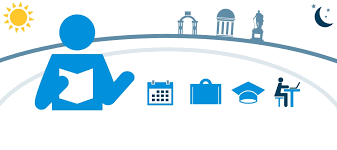



In [28]:
browser.visit(homepage)

courses_i = []
courses_t = []
courses_u = []

anchors =  browser.find_by_css('div.course-info.flex-1')
for i, anchor in enumerate(anchors):
    soup = BeautifulSoup(anchor.html, 'lxml').find('a')
    courses_i.append(str(i+1))
    courses_t.append(anchor.find_by_css('h4').text)
    courses_u.append(soup['href'])
    print(str(i+1), anchor.find_by_css('h4').text)

try:
    chosen_course = input('Choose a course number from [1] to ['+ str(len(courses_i))+']:\n')
except:
    chosen_course = 1

1 Neural Networks for Machine Learning
2 Convolutional Neural Networks
3 Sequence Models
4 Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization
5 Structuring Machine Learning Projects
6 Neural Networks and Deep Learning
7 Fundamentals of Machine Learning in Finance
8 Guided Tour of Machine Learning in Finance
9 Valuation: Alternative Methods
10 Valuing Companies
11 Exploratory Data Analysis
12 Reproducible Research
Choose a course number from [1] to [12]:
8


In [29]:
courses = zip(courses_i, courses_t, courses_u)
chosen_courses =[]

for e in chosen_course.split(','):
    chosen_courses.append(e.strip())
chosen_courses
print('>> You choose:')
for e in chosen_courses:
    course_title = courses_t[int(e)-1]
    print(e + ' '+course_title)

>> You choose:
8 Guided Tour of Machine Learning in Finance


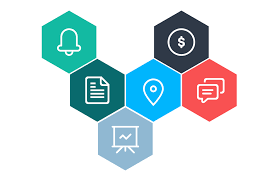

### Download Lecture Videos and Readings
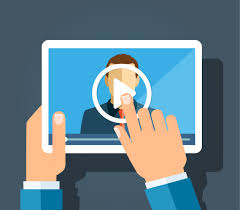

See the progress of downloading lecture videos, readings and quizzes.

In [50]:
for e in chosen_courses:
    
    course_title = courses_t[int(e)-1]
    print(e + ' '+course_title)
    lecture_homepage = homepage + courses_u[int(e)-1]
    os.chdir(initial_dirname)
    create_download_dir(courses_t[ int(e)- 1])
        
    a,b,c = enumerate_lessons(lecture_homepage)
    lessons = zip(a,b,c)
    
    download_videos(lessons)
    #create_m3u_playlist(course_title)
    
    download_quiz(lessons)
    download_html(lessons)
    
    os.chdir(initial_dirname)
    print('download finished')

8 Guided Tour of Machine Learning in Finance
/home/bri/Development/my-github/www-coursera-downloader/Guided Tour of Machine Learning in Finance
weeks list/learn/guided-tour-machine-learning-finance/home/week/1
/learn/guided-tour-machine-learning-finance/home/week/2
/learn/guided-tour-machine-learning-finance/home/week/3
/learn/guided-tour-machine-learning-finance/home/week/4
There are 18 lesson titles available to check.ce/programming/qoIPX/euclidean-distance-calculationng-with-scikit-learn-and-tensorflow-chapter-1                                                                                                                                                    
There are 33 lesson titles available to check.ce/programming/dX8oQ/linear-regressionaqcal-modeling-the-two-cultureshapters-4-5-5-1-5-2-5-3-5-4                                                                                                                                                    
There are 44 lesson titles available to 

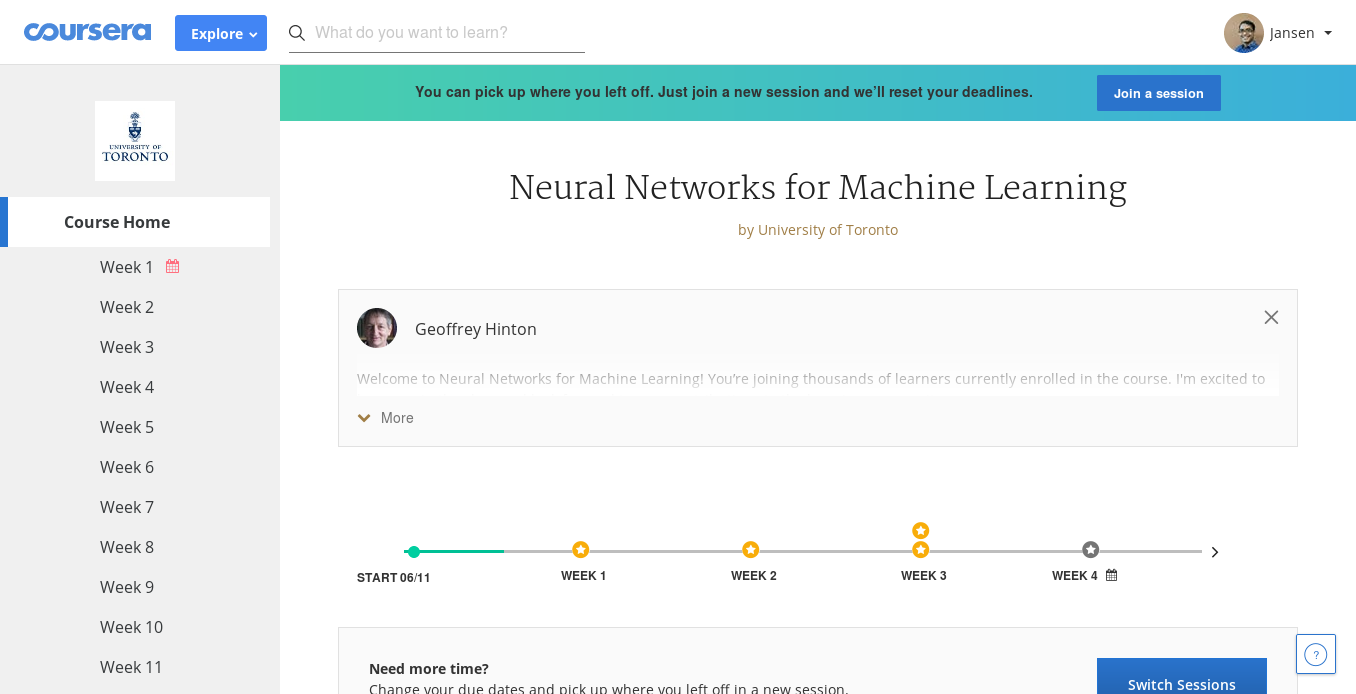

In [20]:
screenshot()

## <a name='#download'><b style="color:#3b5998">D. Download Another Course?</b></a>

<a href="#last-active-courses">YES, Click Here</a> 

- then RUN the cells on LAST ACTIVE COURSES and continue to choose another course. 
- You may want to use your browser and open the corresponding course if the course is not seen the last active course list.

<a href="#close">NO, quit</a> 

- then RUN the cells with `browser.quit()` command.

##  <a name='error'><b style="color:#3b5998">E. Error Checking</b></a>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXcI6o52Fkp4wQV6fET12lDBZl1ZfqQpwdGP9265fpkVu3hc6k8Q">

### <b style="color:#3b5998">(1) Current URL Checking</b>

In case of an error, you may want to check the current URL and reload the current URL.

In [ ]:
browser.driver.current_url

#### Reload Current URL

In [ ]:
browser.visit(browser.driver.current_url)

###  <b style="color:#3b5998">(2) Current Screenshot Checking</b>

In case of an error, you may also want to check the screenshot.

If the screenshot is blank, then the page was not yet loaded into the browser. Please try again or check your network connection.

In [ ]:
screenshot()

###  <b style="color:#3b5998">(3) Manually Calling Downloader Functions</b>

In [ ]:
resource_idx = {}
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    resource_idx[a] = {'title':b, 'url':c}

# USER'S HELPER FUNCTIONS

def quiz_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    quiz_downloader(a, b, c)
    
def mp4_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    mp4_downloader(a, b, c) 
    
def html_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    html_downloader(a, b, c)
    
def vtt_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    vtt_downloader(a, b, c)

### <b style="color:green">Examples of Manually Calling Functions</b>
<img src="https://images-na.ssl-images-amazon.com/images/I/41IRMu3-78L.jpg">

**`mp4_download_by_id`**

Example usage:

```
mp4_download_by_id('103')
```
is equivalent to:

**`mp4_downloader`** 

```
mp4_downloader('103',
               'Lecture Meet your lecturers',
               '/learn/competitive-data-science/lecture/k0D2h/meet-your-lecturers')
```
`103` means week `1` sequence number `03` which is a lecture

**`quiz_download_by_id`**
```
quiz_download_by_id('406')
```
is equivalent to:

**`quiz_downloader`** 

```
quiz_downloader('406',
               'Practice Quiz Practice quiz', 
               '/learn/competitive-data-science/quiz/k7xTP/practice-quiz')
```
`406` means week `4` sequence number `06` which is a quiz

In [ ]:
# Example usage, edit and uncomment as you wish
#mp4_download_by_id('103')
resource_idx['307']['url']

## <a name="close"> <b style="color:#3b5998">F. Finally Close the Browser After Download</b></a>

In [25]:
browser.quit()
os.chdir(initial_dirname)
os.getcwd()

[Errno 2] No such file or directory: '/tmp/tmpn50q4rjl'


'/home/bri/Development/my-github/www-coursera-downloader'

## <a name='goodbye'><b style="color:#3b5998">G. Good Bye</b></a>
<img src="https://media.tenor.com/images/33c7bbf779e792d8a25ba1e5b80d8c9f/tenor.gif">

## <b style="color:#3b5998">Going Back to Login?</b>
Click <a href='#login'>here</a> to restart login.

## <b style="color:#3b5998">Going Back to Table of Contents?</b>
Click <a href='#toc'>here</a> to go back to table of contents.